# Banana collector

---

In this notebook, we will train DQN agent to pick up yellow bananas while avoiding blue ones in Unity ML-Agents environment.

### 1. Start the Environment

We begin by importing some necessary packages and srarting Unity environment.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed necessary packages.

In [1]:
from unityagents import UnityEnvironment
from collections import deque

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils.config 
import pprint
import torch

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Create instance of agent

Agent's hyperparameters are saved and loaded from config.py file in utils folder. Current values are result of selected after hyperparameter tuing. But you can try different hyperparameter values if you want. 

In [2]:
from agents.ddqn_agent import DDQN

# Load parameters from file
hparams = utils.config.HYPERPARAMS['DDQN']
params = utils.config.TRAINPARAMS['BananaCollector']

# Create agent instance
agent = DDQN(hparams)
print("Created agent with following hyperparameter values:")
pprint.pprint(hparams)

Created agent with following hyperparameter values:
{'action_size': 4,
 'batch_size': 256,
 'buffer_size': 100000,
 'fc1_units': 32,
 'fc2_units': 32,
 'gamma': 0.99,
 'learning_rate': 0.001,
 'name': 'DDQN',
 'seed': 0,
 'state_size': 37,
 'tau': 0.001,
 'update_every': 4}


### 3. Train the agent!

In [3]:
# Reset and set environment to training mode
env_info = env.reset(train_mode=True)[brain_name]

# Maximum number of training episodes
n_episodes = params['n_episodes']
# Initialize epsilon
epsilon = params['epsilon_start']
# List containing scores from each episode
scores = []
# Store last 100 scores
scores_window = deque(maxlen=params['scores_window_size'])

# Train loop
for i_episode in range(1, n_episodes+1):
    # Reset environment
    env_info = env.reset(train_mode=True)[brain_name]

    # Observe current state
    state = env_info.vector_observations[0]

    # Reset score and done flag
    score = 0
    done = False

    # Loop each episode
    while not done:

        # Select action with e-greedy policy
        action = agent.act(state, epsilon)

        # Take action
        env_info = env.step(action)[brain_name]

        # Observe the next state
        next_state = env_info.vector_observations[0]

        # Get the reward
        reward = env_info.rewards[0]

        # Check if episode is finished
        done = env_info.local_done[0]

        # Store experience
        agent.step(state, action, reward, next_state, done)

        # State transition
        state = next_state

        # Update total score
        score += reward

    # Save most recent score
    scores_window.append(score)
    scores.append([score, np.mean(scores_window)])

    # Decay epsilon
    epsilon = max(params['epsilon_final'], params['epsilon_decay']*epsilon)

    # Print learning progress
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % params['scores_window_size'] == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=params['solve_score']:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        # Filename string
        filename = "{:s}_lr{:.1E}_batch{:d}_model{:d}x{:d}_buffer{:d}_update{:d}_solved{:d}"
        filename = filename.format(hparams['name'], hparams['learning_rate'], hparams['batch_size'], hparams['fc1_units'], hparams['fc2_units'], hparams['buffer_size'], hparams['update_every'], i_episode-100)
        torch.save(agent.qnetwork_local.state_dict(), 'models/{:s}.pth'.format(filename))
        print('Saved model weight as models/{:s}.pth'.format(filename))
        break


Episode 100	Average Score: 0.50
Episode 200	Average Score: 3.46
Episode 300	Average Score: 6.19
Episode 400	Average Score: 9.78
Episode 471	Average Score: 13.00
Environment solved in 371 episodes!	Average Score: 13.00
Saved model weight as models/DDQN_lr1.0E-03_batch256_model32x32_buffer100000_update4_solved371.pth


### 4. Save and Plot score

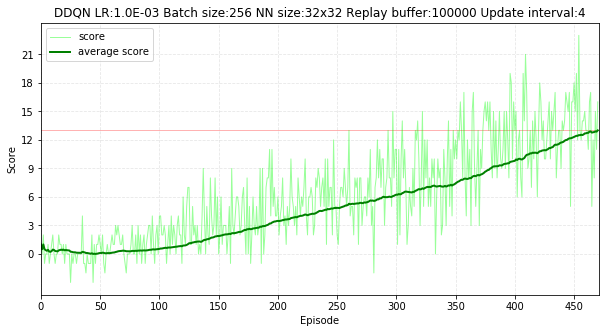

In [4]:
# Save score
df = pd.DataFrame(scores,columns=['scores','average_scores'])
df.to_csv('scores/{:s}.csv'.format(filename))

# Plot scores
plt.figure(figsize=(10,5))
plt.axhline(13, color='red', lw=1, alpha=0.3)
plt.plot( df.index, 'scores', data=df, color='lime', lw=1, label="score", alpha=0.4)
plt.plot( df.index, 'average_scores', data=df, color='green', lw=2, label="average score")
# Set labels and legends
plt.xlabel('Episode')
plt.xlim(0, len(df.index))
plt.xticks(50*np.arange(int(len(df.index)/50+1)))
plt.ylabel('Score')
plt.yticks(3*np.arange(8))
title_str = "{:s} LR:{:.1E} Batch size:{:d} NN size:{:d}x{:d} Replay buffer:{:d} Update interval:{:d}"
title_str = title_str.format(hparams['name'], hparams['learning_rate'], hparams['batch_size'], 
                             hparams['fc1_units'], hparams['fc2_units'], 
                             hparams['buffer_size'], hparams['update_every'])
plt.title(title_str)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend()
# Save figure
plt.savefig('docs/plots/{:s}.png'.format(filename), bbox_inches='tight')
plt.show()

### 5. Watch smart agent
If you are skipped training, please specify filename for pre-trained network model.

In [6]:
# Speed (False: Real time, True: Fast)
train_mode = False

# reset the environment
env_info = env.reset(train_mode=train_mode)[brain_name]

# Load learned model weight. Load 'models/best_model.pth' for optimal model
#model_filename = 'models/best_model.pth'
model_filename = 'models/{:s}.pth'.format(filename)
agent.qnetwork_local.load_state_dict(torch.load(model_filename))

# Number of episodes to run
n_episodes = 3

# Run loop
for i_episode in range(1, n_episodes+1):
    # Reset environment
    env_info = env.reset(train_mode=train_mode)[brain_name]

    # Observe current state
    state = env_info.vector_observations[0]

    # Reset score and done flag
    score = 0
    done = False

    # Episode loop
    while not done:

        # Select action with greedy policy
        action = agent.act(state)

        # Take action
        env_info = env.step(action)[brain_name]

        # Observe the next state
        next_state = env_info.vector_observations[0]

        # Get the reward
        reward = env_info.rewards[0]

        # Check if episode is finished
        done = env_info.local_done[0]

        # State transition
        state = next_state

        # Update total score
        score += reward

    # Print episode summary
    print('Episode %d Score:%d'%(i_episode, score))

Episode 1 Score:11
Episode 2 Score:11
Episode 3 Score:18


In [7]:
# Close the environment
env.close()